# skybot 이용하여 소행성 찾기

* 이 노트북을 구글 코랩에서 실행하고자 한다면 [파일] - [드라이브에 사본 저장]을 하여 본인의 소유로 만든 후에 코드를 실행하거나 수정할 수 있습니다.

* 이 파일은 실제 수업에 사용하므로 필요에 따라 예고 없이 변경될 수 있습니다.

* If you have any questions or comments on this document, please email me(Kiehyun.Park@gmail.com).

* 이 파일(문서)는 공교육 현장에서 수업시간에 자유롭게 사용할 수 있으나, 다른 목적으로 사용할 시에는 사전에 연락을 주셔서 상의해 주시기 바랍니다.



천체 관측 중 CCD(charge couple device) 관측 자료를 이용하여 소행성을 찾아봅니다.

## 필요한 환경

### 한글 폰트 설치 (matplotlib에서 한글 폰트 깨질 경우)

구글 코랩에서 현재의 Jupyter notebook을 실행한다면 matplotlib 그래프에 한글을 사용하기 위해서 폰트를 설치해야 합니다.

아래 코드의 주석을 제거한 후에 셀을 실해 주세요. 그리고 나서 런타임 다시 시작을 해 줘야 matplotlib 그래프에서 한글을 사용할 수 있습니다.

In [47]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

#### 런타임 다시 시작

위의 셀을 실행한 다음 반드시 다음 과정을 수행해야 합니다.

* [메뉴]-[런타임]-[런터임 다시 시작]

* [메뉴]-[런타임]-[이전 셀 실행]

#### 한글 폰트 사용

위에서 한글 폰트를 설치하고, 런타임 다시시작을 했다면 구글 코랩에서 폰트 경로를 설정하여 한글 사용이 가능해 집니다.

In [48]:
#visualization
import matplotlib as mpl
import matplotlib.pylab as pl
import matplotlib.pyplot as plt

# 브라우저에서 바로 그려지도록
%matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumBarunGothic')

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

plt.rcParams.update({'figure.max_open_warning': 0})

import warnings
warnings.filterwarnings('ignore')

### 모듈 설치 및 버전 확인

아래 셀을 실행하면 이 노트북을 실행하는데 필요한 모듈을 설치하고 파이썬 및 관련 모듈의 버전을 확인할 수 있습니다.

In [49]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ysfitsutilpy, ysphotutilpy, ccdproc, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
        print(f"**** {pkg} module is now being installed.")
    else:
        print(f"******** {pkg} module is already installed.")
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

******** numpy module is already installed.
******** pandas module is already installed.
******** matplotlib module is already installed.
******** scipy module is already installed.
******** astropy module is already installed.
******** astroquery module is already installed.
******** photutils module is already installed.
******** ysfitsutilpy module is already installed.
******** ysphotutilpy module is already installed.
******** ccdproc module is already installed.
******** version_information module is already installed.
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2024-12-02 06:44:23 (UTC = GMT+0000) 
0 Python     3.10.12 64bit [GCC 11.4.0]
1 IPython    7.34.0
2 OS         Linux 6.1.85+ x86_64 with glibc2.35
3 numpy      1.26.4
4 pandas     2.2.2
5 matplotlib 3.8.0
6 scipy      1.13.1
7 astropy    6.1.6
8 astroquery 0.4.7
9 photutils  2.0.2
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdpr

## 데이터 저장

### FITS 파일 저장 폴더 생성

FITS 파일을 저장할 폴더를 "Check_asteroids" 이라는 이름으로 생성해 보겠습니다.

* 만약 리눅스 시스템 이라면 shell 명령어로 가능한데, "!"를 붙이면 shell 명령어를 실행할 수 있습니다.
> !mkdir Check_asteroids

OS의 영향을 받지 않기 위하여 pathlib을 사용하여 폴더를 생성하겠습니다.

In [50]:
import os
from pathlib import Path
BASEPATH = Path("./")
save_dir_name = "Check_asteroids"
print(f"BASEPATH: {BASEPATH}")

if not (BASEPATH/save_dir_name).exists():
    os.mkdir(str(BASEPATH/save_dir_name))
    print (f"{str(BASEPATH/save_dir_name)} is created...")
else :
    print (f"{str(BASEPATH/save_dir_name)} is already exist...")

BASEPATH: .
Check_asteroids is already exist...


### FITS 파일 다운로드

나의 구글 드라이브에 저장된 CCD 관측 파일을 다운받아 보겠습니다.

GNU Wget은 HTTP 통신 또는 FTP 통신을 사용해 서버에서 파일 또는 콘텐츠를 다운로드할 때 사용하는 소프트웨어입니다. Wget의 특징은 여러 파일을 한 번에 다운로드하거나 웹 페이지의 링크를 순회하며 여러 콘텐츠를 자동으로 다운로드할 때 매우 편리합니다.

MS Windows에서는 별도로 설치를 해줘야 하며,
구글 코랩도 wget을을 지원해주니 아래 셀을 실행하면 자신의 [작업 영역]에 저장된다. 하지만 이 파일은 이 런타임이 재실행 될때는 삭제됨에 유의하시기 바랍니다.

아래 코드를 실행하면 여러분의 작업영역에 해당 파일을 저장해 줄 것입니다.



In [51]:
fname0 = "127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits"
fid0 = "1VMtgXTksKZ81yjB5c-CsWHRjEV4ww3iC"

fname1 = "144VIBILIA_LIGHT_R_2023-11-13-15-49-02_150sec_RiLA600_STX-16803_-30c_1bin.fits"
fid1 = "11HmeouLUzoEVszaB2_4ZdPvBzGvR0Hmp"


# wget을 이용(나의 구글드라이브에서 공유한 파일을 구글 코랩에서 사용할 경우)
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid0}" -O {save_dir_name}/{fname0}
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid1}" -O {save_dir_name}/{fname1}

--2024-12-02 06:44:24--  https://docs.google.com/uc?export=download&id=1VMtgXTksKZ81yjB5c-CsWHRjEV4ww3iC
Resolving docs.google.com (docs.google.com)... 142.250.31.100, 142.250.31.113, 142.250.31.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.31.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1VMtgXTksKZ81yjB5c-CsWHRjEV4ww3iC&export=download [following]
--2024-12-02 06:44:24--  https://drive.usercontent.google.com/download?id=1VMtgXTksKZ81yjB5c-CsWHRjEV4ww3iC&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.63.132, 2607:f8b0:4004:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.63.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34061760 (32M) [application/octet-stream]
Saving to: ‘Check_asteroids/127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1

### 데이터 확인

* 코랩을 사용할 경우에는 오른쪽의 [파일]창에서 확인할 수 있습니다.
* linux shell 명령어로 다음과 같이 확인해 볼 수 있습니다.
> !ls -l Check_asteroids

OS의 영향을 받지 않고 파이썬으로 확인하는 방법은 아래와 같이 하면 됩니다.

In [52]:
!ls -l Check_asteroids

total 117164
-rw-r--r-- 1 root root    88985 Dec  2 05:39 127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin_AST_Mag16_00.png
-rw-r--r-- 1 root root     1777 Dec  2 05:38 127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin_AST_Mag16.csv
-rw-r--r-- 1 root root  1086520 Dec  2 05:38 127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin_AST_Mag16.png
-rw-r--r-- 1 root root 34061760 Nov 19  2023 127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits
-rw-r--r-- 1 root root     1777 Dec  2 05:55 144VIBILIA_LIGHT_R_2023-11-13-15-49-02_150sec_RiLA600_STX-16803_-30c_1bin_AST_Mag16.csv
-rw-r--r-- 1 root root   687666 Dec  2 05:55 144VIBILIA_LIGHT_R_2023-11-13-15-49-02_150sec_RiLA600_STX-16803_-30c_1bin_AST_Mag16.png
-rw-r--r-- 1 root root 67207680 Nov 19  2023 144VIBILIA_LIGHT_R_2023-11-13-15-49-02_150sec_RiLA600_STX-16803_-30c_1bin.fits
-rw-r--r-- 1 root root 16824960 Sep 17 14:57 914PALISANA_LIGHT_R_2016-1

In [53]:
fpaths = sorted(list((BASEPATH/save_dir_name).glob('*.fit*')))
print(f"fpaths: {fpaths}")
print(f"len(fpaths): {len(fpaths)}")

fpaths: [PosixPath('Check_asteroids/127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits'), PosixPath('Check_asteroids/144VIBILIA_LIGHT_R_2023-11-13-15-49-02_150sec_RiLA600_STX-16803_-30c_1bin.fits'), PosixPath('Check_asteroids/914PALISANA_LIGHT_R_2016-10-31-16-45-43_100sec_RiLA600_STX-16803_-30c_2bin.fit')]
len(fpaths): 3


##  FITS handling

### Load files

첫번째 파일에서 fits file을  읽어 확인해 보겠습니다.

In [54]:
from astropy.io import fits

fpath = Path(fpaths[0])
print(f"fpath: {fpath}")
print(f"type(fpath): {type(fpath)}")

hdul = fits.open(str(fpath), unit="adu")

print("type(hdul) :", type(hdul))
print("type(hdul[0]) :", type(hdul[0]))

fpath: Check_asteroids/127JOHANNA_LIGHT_B_2023-11-17-17-11-55_150sec_GSON300_STF-8300M_-31c_1bin.fits
type(fpath): <class 'pathlib.PosixPath'>
type(hdul) : <class 'astropy.io.fits.hdu.hdulist.HDUList'>
type(hdul[0]) : <class 'astropy.io.fits.hdu.image.PrimaryHDU'>


### header

ccds라는 이름에 HDUList들이 리스트 형태로 들어 있습니다. 각각의 hdulist는 2차원 이므로 index는 [0]번만 존재합니다.

In [55]:
print("type(hdul[0].hedaer) :", type(hdul[0].header))
hdul[0].header

type(hdul[0].hedaer) : <class 'astropy.io.fits.header.Header'>


SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3352                                                  
NAXIS2  =                 2532                                                  
FITS-TLM= '2023-11-18T08:55:11' / UT of last modification of this FITS file     
IMAGETYP= 'LIGHT'              / Type of exposure                               
EXPOSURE=                150.0 / [s] Exposure duration                          
EXPTIME =                150.0 / [s] Exposure duration                          
DATE-LOC= '2023-11-18T02:11:55.783' / Time of observation (local)               
DATE-OBS= '2023-11-17T17:11:55.783' / Time of observation (UTC)                 
DATE-AVG= '2023-11-17T17:13:11.149' / Averaged midpoint time (UTC)              
XBINNING=                   

header는 key와 value가 들어 있습니다.

In [56]:
print("hdul[0].hedaer['DATE-OBS'] :", hdul[0].header['DATE-OBS'])
print("type(hdul[0].hedaer['DATE-OBS']) :", type(hdul[0].header['DATE-OBS']))

hdul[0].hedaer['DATE-OBS'] : 2023-11-17T17:11:55.783
type(hdul[0].hedaer['DATE-OBS']) : <class 'str'>


### data

관측 자료는 numpy.ndarray 형태로 들어 있음을 알 수 있습니다.

In [57]:
print("type(hdul[0].data) :", type(hdul[0].data))
print("hdul[0].data.dtype :", hdul[0].data.dtype)
print("hdul[0].data.shape :", hdul[0].data.shape)
print("hdul[0].data :", hdul[0].data)

type(hdul[0].data) : <class 'numpy.ndarray'>
hdul[0].data.dtype : >f4
hdul[0].data.shape : (2532, 3352)
hdul[0].data : [[5488.5103 5643.993  5607.405  ... 5597.4023 5296.901  5393.7783]
 [5686.813  5568.4663 5528.624  ... 5456.1777 5559.1084 5276.691 ]
 [5753.5747 5488.151  5570.1577 ... 5699.236  5478.6987 5446.0586]
 ...
 [5476.2046 5277.58   5498.8877 ... 5474.3584 5448.752  5418.267 ]
 [5474.3584 5415.4272 5512.9824 ... 5479.693  5644.334  5375.379 ]
 [5526.5186 5473.9536 5373.601  ... 5424.25   5676.565  5592.3154]]


## 소행성 찾기

### 관측소, 관측 장비 설정

In [58]:
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

# observatory
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
Suwon = EarthLocation(lon=127.005 * u.deg,
                                 lat=37.308889 * u.deg,
                                 height=101 * u.m)
observatory_code = "P64"

#####################################################################
# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# optic and ccd
if hdul[0].header["CCDNAME"] == "STF-8300M" :
    val_figsize = (12, 9)
    gain = 0.37
    rdnoise = 9.3
    pix_size = 5.4 * u.um
    val_fraction = 0.035

if hdul[0].header["CCDNAME"] == "STX-16803" :
    val_figsize = (10, 9)
    gain = 1.27
    rdnoise = 9.0
    pix_size = 9 * u.um
    val_fraction = 0.0455

if hdul[0].header["OPTIC"] == "GSON300" :
    focal_length = 1200 * u.mm

if hdul[0].header["OPTIC"] == "RiLA600" :
    focal_length = 3000 * u.mm

print("rdnoise, gain, pix_size, focal_length :", rdnoise, gain, pix_size, focal_length)


#######################################################
# PIXSCALE
if 'PIXSCALE' in hdul[0].header:
    PIX2ARCSEC = hdul[0].header['PIXSCALE']
else :
    PIX2ARCSEC = 206265 * hdul[0].header['XPIXSZ'] ( hdul[0].header['XBINNING']  * hdul[0].header['FOCALLEN'])

PIX2ARCSEC = PIX2ARCSEC # * u.arcsec / u.pixel
print("PIX2ARCSEC :", PIX2ARCSEC)

rdnoise, gain, pix_size, focal_length : 9.3 0.37 5.4 um 1200.0 mm
PIX2ARCSEC : 0.9281925000000001


### aperture 설정

In [59]:
#####################################################################
# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

Mag_UP = 16
#######################################################

### 관측 시각

In [60]:
from astropy.time import Time
# Find the observation time and exposure time to set the obs time
t_start = Time(hdul[0].header['DATE-OBS'], format='isot')
t_expos = hdul[0].header['EXPTIME'] * u.s
t_middle = t_start + t_expos / 2 # start time + 0.5 * exposure time
print(f"t_start: {t_start}, t_expos: {t_expos}, t_middle: {t_middle}")

t_start: 2023-11-17T17:11:55.783, t_expos: 150.0 s, t_middle: 2023-11-17T17:13:10.783


## 소행성 찾기

### check solve

아래 함수를 이용하여 fits file이 plate solving이 되어 있는지 체크해 봅시다.

In [61]:
#########################################
# checkPSolve
#########################################
def checkPSolve(fpath,
                    **kwargs,
                    ):
    """
    Parameters
    ----------
    fpath : path-like
        The path to the original FITS file.

    return
    ----------
    SOLVE, ASTAP, LOCAL :  bool, bool, bool

    """

    fpath = Path(fpath)
    hdul = fits.open(fpath)
    PSKeys = ["CD1_1", "CD1_2", "CD2_1", "CD2_2",
              "A_0_0", "A_0_1", "A_1_0","A_1_1",
              "PC1_1", "PC1_2", "PC2_1", "PC2_2", ]

    chk = 0
    SOLVE = False
    ASTAP = False
    LOCAL = False

    for PSKey in PSKeys :
        if PSKey in hdul[0].header :
            chk += 1
    if chk > 3 :
        SOLVE = True
        LOCAL = False
        ASTAP = False
        try :
            for comment in hdul[0].header["COMMENT"]:
                if "scale:" in comment :
                    LOCAL = True
        except :
            LOCAL = False

        if "PLTSOLVD" in hdul[0].header:
            try :
                ASTAP = hdul[0].header["PLTSOLVD"]
            except :
                ASTAP = False
    else :
        SOLVE = False
        ASTAP = False
        LOCAL = False
    hdul.close()

    return SOLVE, ASTAP, LOCAL

SOLVE, ASTAP, LOCAL = checkPSolve(str(fpath))
print("SOLVE, ASTAP, LOCAL :", SOLVE, ASTAP, LOCAL)

SOLVE, ASTAP, LOCAL : True True True


### 이미지 중심 좌표

아래와 같이 이미지 중심의 좌표를 구할 수 있습니다.

In [62]:
from astropy.wcs import WCS
import ysfitsutilpy as yfu

wcs = WCS(hdul[0].header)

cent_coord = yfu.center_radec(ccd_or_header=hdul[0].header,
                                center_of_image=True)

offset_RA = (cent_coord.ra.to(u.deg) - hdul[0].header['RA']*u.deg).to(u.arcmin)
offset_DEC = (cent_coord.dec.to(u.deg) - hdul[0].header['DEC']*u.deg).to(u.arcmin)
altaz = AltAz(obstime=t_middle, location=Suwon)
cent_aa = cent_coord.transform_to(altaz)
offset_AZ = (cent_aa.az.to(u.deg) - hdul[0].header['CENTAZ']*u.deg).to(u.arcmin)
offset_ALT = (cent_aa.alt.to(u.deg) - hdul[0].header['CENTALT']*u.deg).to(u.arcmin)

print(f"image center (RA, DEC): ({cent_coord.ra:.03f}, {cent_coord.dec:.03f})")
print(f"telescope center (RA, DEC): ({hdul[0].header['RA']*u.deg:.03f}, {hdul[0].header['RA']*u.deg:.03f})")
print(f"offset (RA, DEC): ({offset_RA:.03f}, {offset_DEC:.03f})")
print(f"offset (AZ, ALT): ({offset_AZ:.03f}, {offset_ALT:.03f})")

image center (RA, DEC): (29.822 deg, 14.375 deg)
telescope center (RA, DEC): (29.839 deg, 29.839 deg)
offset (RA, DEC): (-1.057 arcmin, -1.994 arcmin)
offset (AZ, ALT): (-12.221 arcmin, 9.502 arcmin)


### 소행성 목록 얻기 (skybot)

[skybot](https://ssp.imcce.fr/webservices/skybot/)에서는 소행성 정보를 제공하고 있고, api를 이용하면 이미지에서 소행성을 찾을 수 있습니다.

In [63]:
from astroquery.imcce import Skybot
results_ast = Skybot.cone_search(cent_coord,
                                    30*u.arcmin,
                                    t_middle)
#print(results_ast.pprint(max_width=80) )

df_ast = results_ast.to_pandas()
df_ast

Number           Name         RA        DEC       Type     V  posunc  \
0      127        Johanna  29.802270  14.376844  MB>Middle  12.4   0.005   
1   583250      2016 FU11  29.862902  14.434652  MB>Middle  21.4   0.052   
2   623816      2020 BE91  29.745574  14.398463   MB>Outer  22.0   0.114   
3    85598      1998 FZ86  29.715252  14.365772   MB>Inner  17.2   0.008   
4   194488      2001 WC55  29.712556  14.358252   MB>Inner  19.8   0.014   
5   444148      2004 XR47  29.718625  14.266853   MB>Inner  20.0   0.032   
6     <NA>     2016 BE122  29.748962  14.237307  MB>Middle  21.5   0.097   
7     <NA>     2015 BH394  29.765759  14.221018   MB>Inner  22.5   1.652   
8   456518      2006 YT21  29.686810  14.253505  MB>Middle  20.8   0.033   
9   146495      2001 SD25  29.983910  14.274907  MB>Middle  19.7   0.024   
10  176607      2002 EN67  29.699415  14.519139   MB>Inner  20.1   0.040   
11    <NA>      2019 UB93  29.736566  14.196003  MB>Middle  20.5   0.024   
12   69774      1998 QN41  29.987289  14.489545   MB>Outer  18.6   0.010   
13  171332      2006 JR45  29.943477  14.163824   MB>Outer  20.1   0.013   
14  451799      2013 HP27  29.921284  14.152952  MB>Middle  21.1   0.032   
15  227814      2007 BE50  29.705593  14.159518   MB>Inner  20.4   0.016   
16    <NA>      2008 KE13  30.103663  14.369143  MB>Middle  22.4   0.056   
17  467554     2007 TP119  29.545057  14.479554   MB>Outer  20.9   0.053   
18    <NA>     2016 AA193  29.615280  14.601332  MB>Middle  23.0   0.025   
19  174893     2004 BW101  29.980757  14.641400  MB>Middle  20.2   0.016   
20    <NA>     2016 PH148  29.875214  14.069298   MB>Inner  21.9   4.958   
21  496643      2016 AW77  29.639600  14.656958  MB>Middle  21.0   0.042   
22   41703      2000 UM50  30.109329  14.581824   MB>Inner  18.0   0.011   
23  626824      2007 XB29  29.531436  14.170994   MB>Inner  21.5   0.045   
24    <NA>      2003 GG60  30.157371  14.511715  MB>Middle  21.9   0.072   
25  226799     2004 RU201  30.186602  14.402037  MB>Middle  20.7   0.020   
26  369293      2009 RN71  30.143858  14.567370  MB>Middle  21.0   0.022   
27  185343      2006 VK46  30.184723  14.267474   MB>Outer  20.6   0.036   
28  251045      2006 RC21  30.203047  14.368443  MB>Middle  20.6   0.019   
29    <NA>      2013 HZ63  29.461008  14.504759  MB>Middle  22.1   0.064   
30  194428      2001 VY70  29.471888  14.545190   MB>Inner  19.7   0.028   
31   13879       6328 P-L  29.930942  14.744511  MB>Middle  18.5   0.010   
32  378939     2008 UZ139  30.153377  14.150566   MB>Outer  21.0   0.027   
33  630020     2004 RU278  29.512169  14.116771  MB>Middle  21.4   0.051   
34  136633       1994 SH6  30.127817  14.106219   MB>Outer  20.2   0.018   
35    <NA>     2016 EH303  29.412093  14.318386   MB>Outer  22.0   0.098   
36  458291      2010 UL81  29.738371  14.770267  MB>Middle  20.8   0.026   
37    <NA>      2022 KG31  30.066044  14.711825  MB>Middle  23.1   0.000   
38    <NA>      2023 UO12  30.153265  14.106491   MB>Inner  21.5  36.350   
39  350869      2002 OY36  30.255090  14.424598  MB>Middle  21.5   0.064   
40    <NA>      2015 AF36  30.191133  14.131737   MB>Outer  21.3   0.074   
41  552856      2010 UG81  30.238190  14.203906  MB>Middle  20.3   0.012   
42  305786      2009 DX62  29.644696  14.780528  MB>Middle  20.7   0.013   
43   36446  Cinodapistoia  30.117722  14.040032   MB>Inner  17.8   0.013   
44    <NA>      2015 KN40  29.752981  14.815233   MB>Inner  20.9   0.032   
45    <NA>     2001 RZ157  29.955587  14.801809   MB>Inner  21.6   0.088   
46   44139      1998 HZ92  29.471722  14.072626   MB>Inner  18.5   0.011   
47    <NA>      2023 TP98  30.229090  14.146909   MB>Inner  21.4   0.522   
48  397069     2005 UF163  29.835270  13.918406   MB>Inner  20.1   0.063   
49  285182      1996 TU18  30.102187  13.993609  MB>Middle  20.1   0.026   
50   31433      1999 BA13  29.500370  14.025333   MB>Inner  19.5   0.010   
51    <NA>      2023 TS80  29.459788  14.693327   MB

#### 목록 필터링

16등급(Mag_UP = 16) 보다 밝은 소행성만 필터링 해 보겠습니다.

In [64]:
df_targ = df_ast[df_ast['V'] < Mag_UP]
df_targ = df_targ.sort_values(by=['V'])
df_targ = df_targ.reset_index(drop=True)
df_targ

Number     Name        RA        DEC       Type     V  posunc  centerdist  \
0     127  Johanna  29.80227  14.376844  MB>Middle  12.4   0.005      68.535   

   RA_rate  DEC_rate  ...  heliodist  alpha   elong         x         y  \
0 -28.7551    -3.929  ...    2.71673   7.85  157.88  2.113807  1.560337   

          z       vx        vy       vz      epoch  
0  0.737063 -0.00708  0.006363  0.00436  2460260.0  

[1 rows x 21 columns]

In [65]:
import pandas as pd
from astroquery.jplhorizons import Horizons

if df_targ.empty:
    pass
else:
    df_targ_eph = pd.DataFrame()

    for i, row in df_targ.iterrows() :
        #print("type(row)", type(row))
        #Query the ephemerides of this target!
        obj = Horizons(id=row['Number'],
                       location=observatory_code,
                       epochs=t_middle.jd)
        obj_ephem = obj.ephemerides()
        #print(obj_ephem)
        df_eph = obj_ephem.to_pandas()
        df_targ_eph = pd.concat([df_targ_eph, df_eph], axis = 0)
    #print(df_targ_eph)
    df_targ_eph = df_targ_eph.reset_index(drop=True)
    df_targ_eph = pd.concat([df_targ, df_targ_eph], axis = 1)
    print("df_targ_eph :", df_targ_eph)

df_targ_eph :    Number     Name        RA        DEC       Type     V  posunc  centerdist  \
0     127  Johanna  29.80227  14.376844  MB>Middle  12.4   0.005      68.535   

   RA_rate  DEC_rate  ...  r_3sigma  r_rate_3sigma  SBand_3sigma  \
0 -28.7551    -3.929  ...    6.5336   8.000000e-07          0.02   

   XBand_3sigma  DoppDelay_3sigma  true_anom  hour_angle  alpha_true   PABLon  \
0          0.08          0.000044   277.4203    3.445096      7.8496  36.6508   

   PABLat  
0   1.724  

[1 rows x 104 columns]


#### 저장하기

In [66]:
duplicated_columns_list = []
list_of_all_columns = list(df_targ_eph.columns)
for column in list_of_all_columns:
    if list_of_all_columns.count(column) > 1 and not column in duplicated_columns_list:
        duplicated_columns_list.append(column)
duplicated_columns_list

for column in duplicated_columns_list:
    list_of_all_columns[list_of_all_columns.index(column)] = column
    list_of_all_columns[list_of_all_columns.index(column)] = column + '_1'

df_targ_eph.columns = list_of_all_columns
#print(df_targ_eph.columns)
df_targ_eph.to_csv(f"{save_dir_name}/{fpath.stem}_AST_Mag{Mag_UP}.csv")
df_targ_eph.dropna(subset = ['RA', 'DEC', 'V', 'RA_1', 'DEC_1', 'V_1'], inplace=True)
df_targ_eph[['RA', 'DEC', 'V', 'RA_1', 'DEC_1', 'V_1']]

RA       DEC       V      RA_1      DEC_1   V_1
0  29.80155  14.37623  12.559  29.80227  14.376844  12.4

## fits file에서 소행성 좌표

fits 파일에서 소행성의 위치를 찾아봅시다.



In [67]:
import numpy as np
pos_sky_targ_init = SkyCoord(df_targ_eph['RA']*u.deg, df_targ_eph["DEC"]*u.deg,
                        **SKYC_KW)
pos_pix_targ_init = SkyCoord(df_targ_eph['RA']*u.deg, df_targ_eph["DEC"]*u.deg,
                        **SKYC_KW).to_pixel(wcs, origin=0, mode='wcs')
pos_pix_targ_init = np.array(pos_pix_targ_init).T
print("pos_pix_targ_init:", pos_pix_targ_init)

pos_pix_targ_init: [[1598.52214962 1270.81229754]]


### def zimshow

In [68]:
from warnings import warn
from astropy.visualization import (
    ImageNormalize,
    LinearStretch,
    ZScaleInterval,
    simple_norm,
)

def znorm(image, stretch=LinearStretch(), **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs), stretch=stretch)

def zimshow(
    ax,
    image,
    stretch=LinearStretch(),
    cmap=None,
    origin="lower",
    zscale_kw={},
    **kwargs
):
    im = ax.imshow(
        image,
        norm=znorm(image, stretch=stretch, **zscale_kw),
        origin=origin,
        cmap=cmap,
        **kwargs
    )
    return im

def norm_imshow(
    ax,
    data,
    origin="lower",
    stretch="linear",
    power=1.0,
    asinh_a=0.1,
    min_cut=None,
    max_cut=None,
    min_percent=None,
    max_percent=None,
    percent=None,
    clip=True,
    log_a=1000,
    invalid=-1.0,
    zscale=False,
    vmin=None,
    vmax=None,
    **kwargs
):
    """Do normalization and do imshow"""
    if vmin is not None and min_cut is not None:
        warn("vmin will override min_cut.")

    if vmax is not None and max_cut is not None:
        warn("vmax will override max_cut.")

    if zscale:
        zs = ImageNormalize(data, interval=ZScaleInterval())
        min_cut = vmin = zs.vmin
        max_cut = vmax = zs.vmax

    if vmin is not None or vmax is not None:
        im = ax.imshow(data, origin=origin, vmin=vmin, vmax=vmax, **kwargs)
    else:
        im = ax.imshow(
            data,
            origin=origin,
            norm=simple_norm(
                data=data,
                stretch=stretch,
                power=power,
                asinh_a=asinh_a,
                min_cut=min_cut,
                max_cut=max_cut,
                min_percent=min_percent,
                max_percent=max_percent,
                percent=percent,
                clip=clip,
                log_a=log_a,
                invalid=invalid
            ),
            **kwargs)
    return im


### 이미지 display

소행성의 위치를 tag 해 볼 수 있습니다.

In [69]:
from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn

fig, axs = plt.subplots(1, 1, figsize=val_figsize,
                        subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

im = zimshow(axs, hdul[0].data, )
axs.set_title('World coordinate system', fontsize=9)
axs.coords.grid(True, color='white', ls=':')
axs.coords['ra'].set_axislabel('Right Ascension (J2000)', minpad=0.5, fontsize=8)
axs.coords['ra'].set_ticklabel_position('bl')
axs.coords['dec'].set_axislabel('Declination (J2000)', minpad=0.4, fontsize=8)
axs.coords['dec'].set_ticklabel_position('bl')
axs.coords['ra'].set_major_formatter('hh:mm')
axs.coords['dec'].set_major_formatter('dd:mm')
axs.coords['ra'].display_minor_ticks(True)
axs.coords['dec'].display_minor_ticks(True)
axs.coords['ra'].set_minor_frequency(2)
axs.coords['dec'].set_minor_frequency(2)
axs.tick_params(labelsize=8)

if df_targ.empty:
    pass
else:
    targ_ap = CAp(pos_pix_targ_init,
            r=R_AP,
            )
    targ_an = CAn(pos_pix_targ_init,
            r_in=R_IN,
            r_out=R_OUT)

    #targ_ap.plot(axs, color="r")
    targ_an.plot(axs, color="r")

    axs.annotate(f"{df_targ_eph[['Number', 'RA', 'DEC', 'V']]}",
            xy=(0, 0), xytext=(0, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize = 6)
plt.colorbar(im, ax = axs, fraction=val_fraction, pad=0.04)
plt.suptitle(f"fname: {fpath.name}")

axs.annotate(f"image center (RA, DEC): ({cent_coord.ra:.03f}, {cent_coord.dec:.03f})\ntelescope center (RA, DEC): ({hdul[0].header['RA']*u.deg:.03f}, {hdul[0].header['RA']*u.deg:.03f})\noffset (RA, DEC): ({offset_RA:.03f}, {offset_DEC:.03f})\noffset (AZ, ALT): ({offset_AZ:.03f}, {offset_ALT:.03f})",
            xy=(0, 0), xytext=(0.6, -0.1),
            xycoords='axes fraction',
            va='top', ha='left',
            fontsize = 6)
plt.tight_layout()
plt.savefig(f"{save_dir_name}/{fpath.stem}_AST_Mag{Mag_UP}.png")
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### 소행성 잘라서 중심찾기

소행성 주변을 잘라서 소행성의 중심을 찾아 보겠습니다.

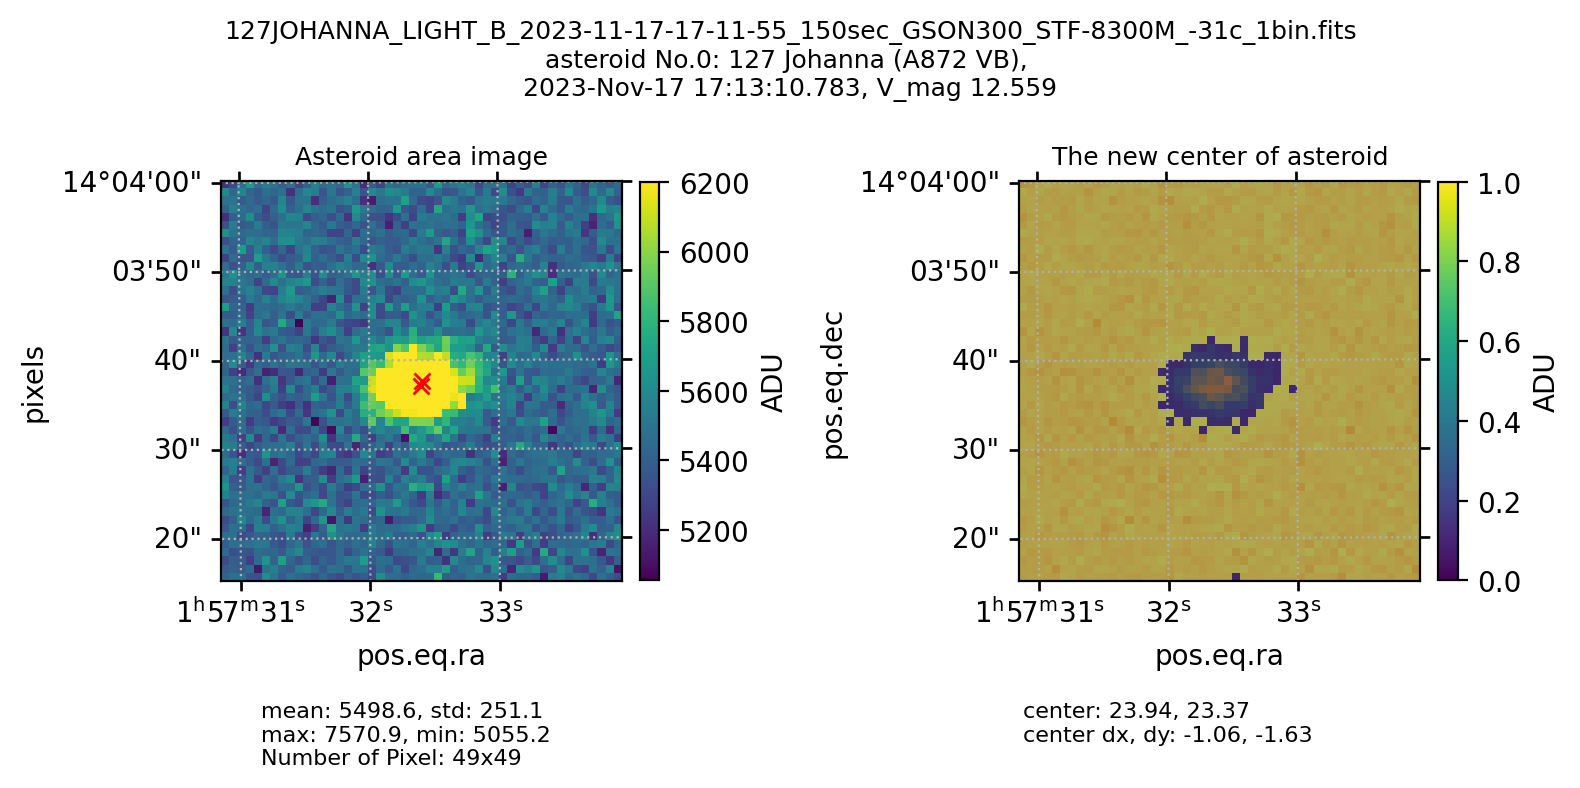

In [70]:
from astropy.nddata import Cutout2D
from photutils.centroids import centroid_com
from astropy.stats import sigma_clip, sigma_clipped_stats

if df_targ.empty:
    pass
else:
    cutsizes = 49
    for i, row in df_targ_eph.iterrows():
        try :
            #1. cut asteroia area
            #print(i)
            cut_hdu = Cutout2D(
                        data = hdul[0].data,
                        position = (pos_pix_targ_init[i]),
                        size=(cutsizes, cutsizes) #cut ccd
                        )
            avg, med, std = sigma_clipped_stats(cut_hdu.data)  # by default, 3-sigma 5-iteration.

            fig, axs = plt.subplots(1, 2, figsize=(8, 4),
                        subplot_kw={'projection': wcs},
                        sharex=False, sharey=False, gridspec_kw=None)

            im0 = zimshow(axs[0], cut_hdu.data)
            axs[0].plot(round(cutsizes/2), round(cutsizes/2), 'rx')
            axs[0].set_ylabel('pixels')
            axs[0].grid(ls=':')
            axs[0].set_title(f'Asteroid area image', fontsize=9)
            axs[0].annotate(   f"mean: {np.mean(cut_hdu.data):.01f}, std: {np.std(cut_hdu.data):.01f} \nmax: {np.max(cut_hdu.data):.01f}, min: {np.min(cut_hdu.data):.01f} \nNumber of Pixel: {np.shape(cut_hdu.data)[0]:.0f}x{np.shape(cut_hdu.data)[1]:.0f}",
                xy=(0, 0), xytext=(0.1, -0.30),
                xycoords='axes fraction',
                va='top', ha='left',
                fontsize=8)
            plt.colorbar(im0,
                        ax=axs[0],
                        label="ADU",
                        fraction=0.0455, pad=0.04)
            #print("Image size is: ", cut_hdu.data.shape)

            #2. Get center dx, dy
            thresh_3sig = med + 3 * std
            mask_3sig = (cut_hdu.data < thresh_3sig)
            center = centroid_com(
                        data = cut_hdu.data,
                        mask = mask_3sig
                        )

            centerdx = center[0] - ((cutsizes+1)/2)
            centerdy = center[1] - ((cutsizes+1)/2)

            # print("type(center):", type(center))
            # print("center:", center)
            # print("center dx, dy:", centerdx, centerdy)

            axs[1].grid(ls=':')
            axs[1].set_title(f'The new center of asteroid', fontsize=9)
            im1 = axs[1].imshow(mask_3sig.astype(int),
                origin="lower")
            axs[1].imshow(cut_hdu.data,
                    alpha=0.4,
                    origin="lower")
            axs[0].plot(*center, 'rx')
            axs[1].annotate(f"center: {center[0]:.02f}, {center[1]:.02f}\ncenter dx, dy: {centerdx:.02f}, {centerdy:.02f}",
                    xy=(0, 0), xytext=(0.01, -0.30),
                    xycoords='axes fraction',
                    va='top', ha='left',
                    fontsize=8)

            plt.colorbar(im1,
                        ax=axs[1],
                        label="ADU",
                        fraction=0.0455, pad=0.04)
            plt.suptitle(f"{fpath.name}\nasteroid No.{i}: {row['targetname']}, \n{row['datetime_str']}, V_mag {row['V']}",
                        fontsize=9)

            plt.tight_layout()
            plt.savefig(f"{save_dir_name}/{fpath.stem}_AST_Mag{Mag_UP}_{i:02d}.png")
            plt.show()
            #plt.close()

        except Exception as err:
            print("Err :", err)
            continue

## (과제)

두번째 파일에서 소행성을 찾아보자.

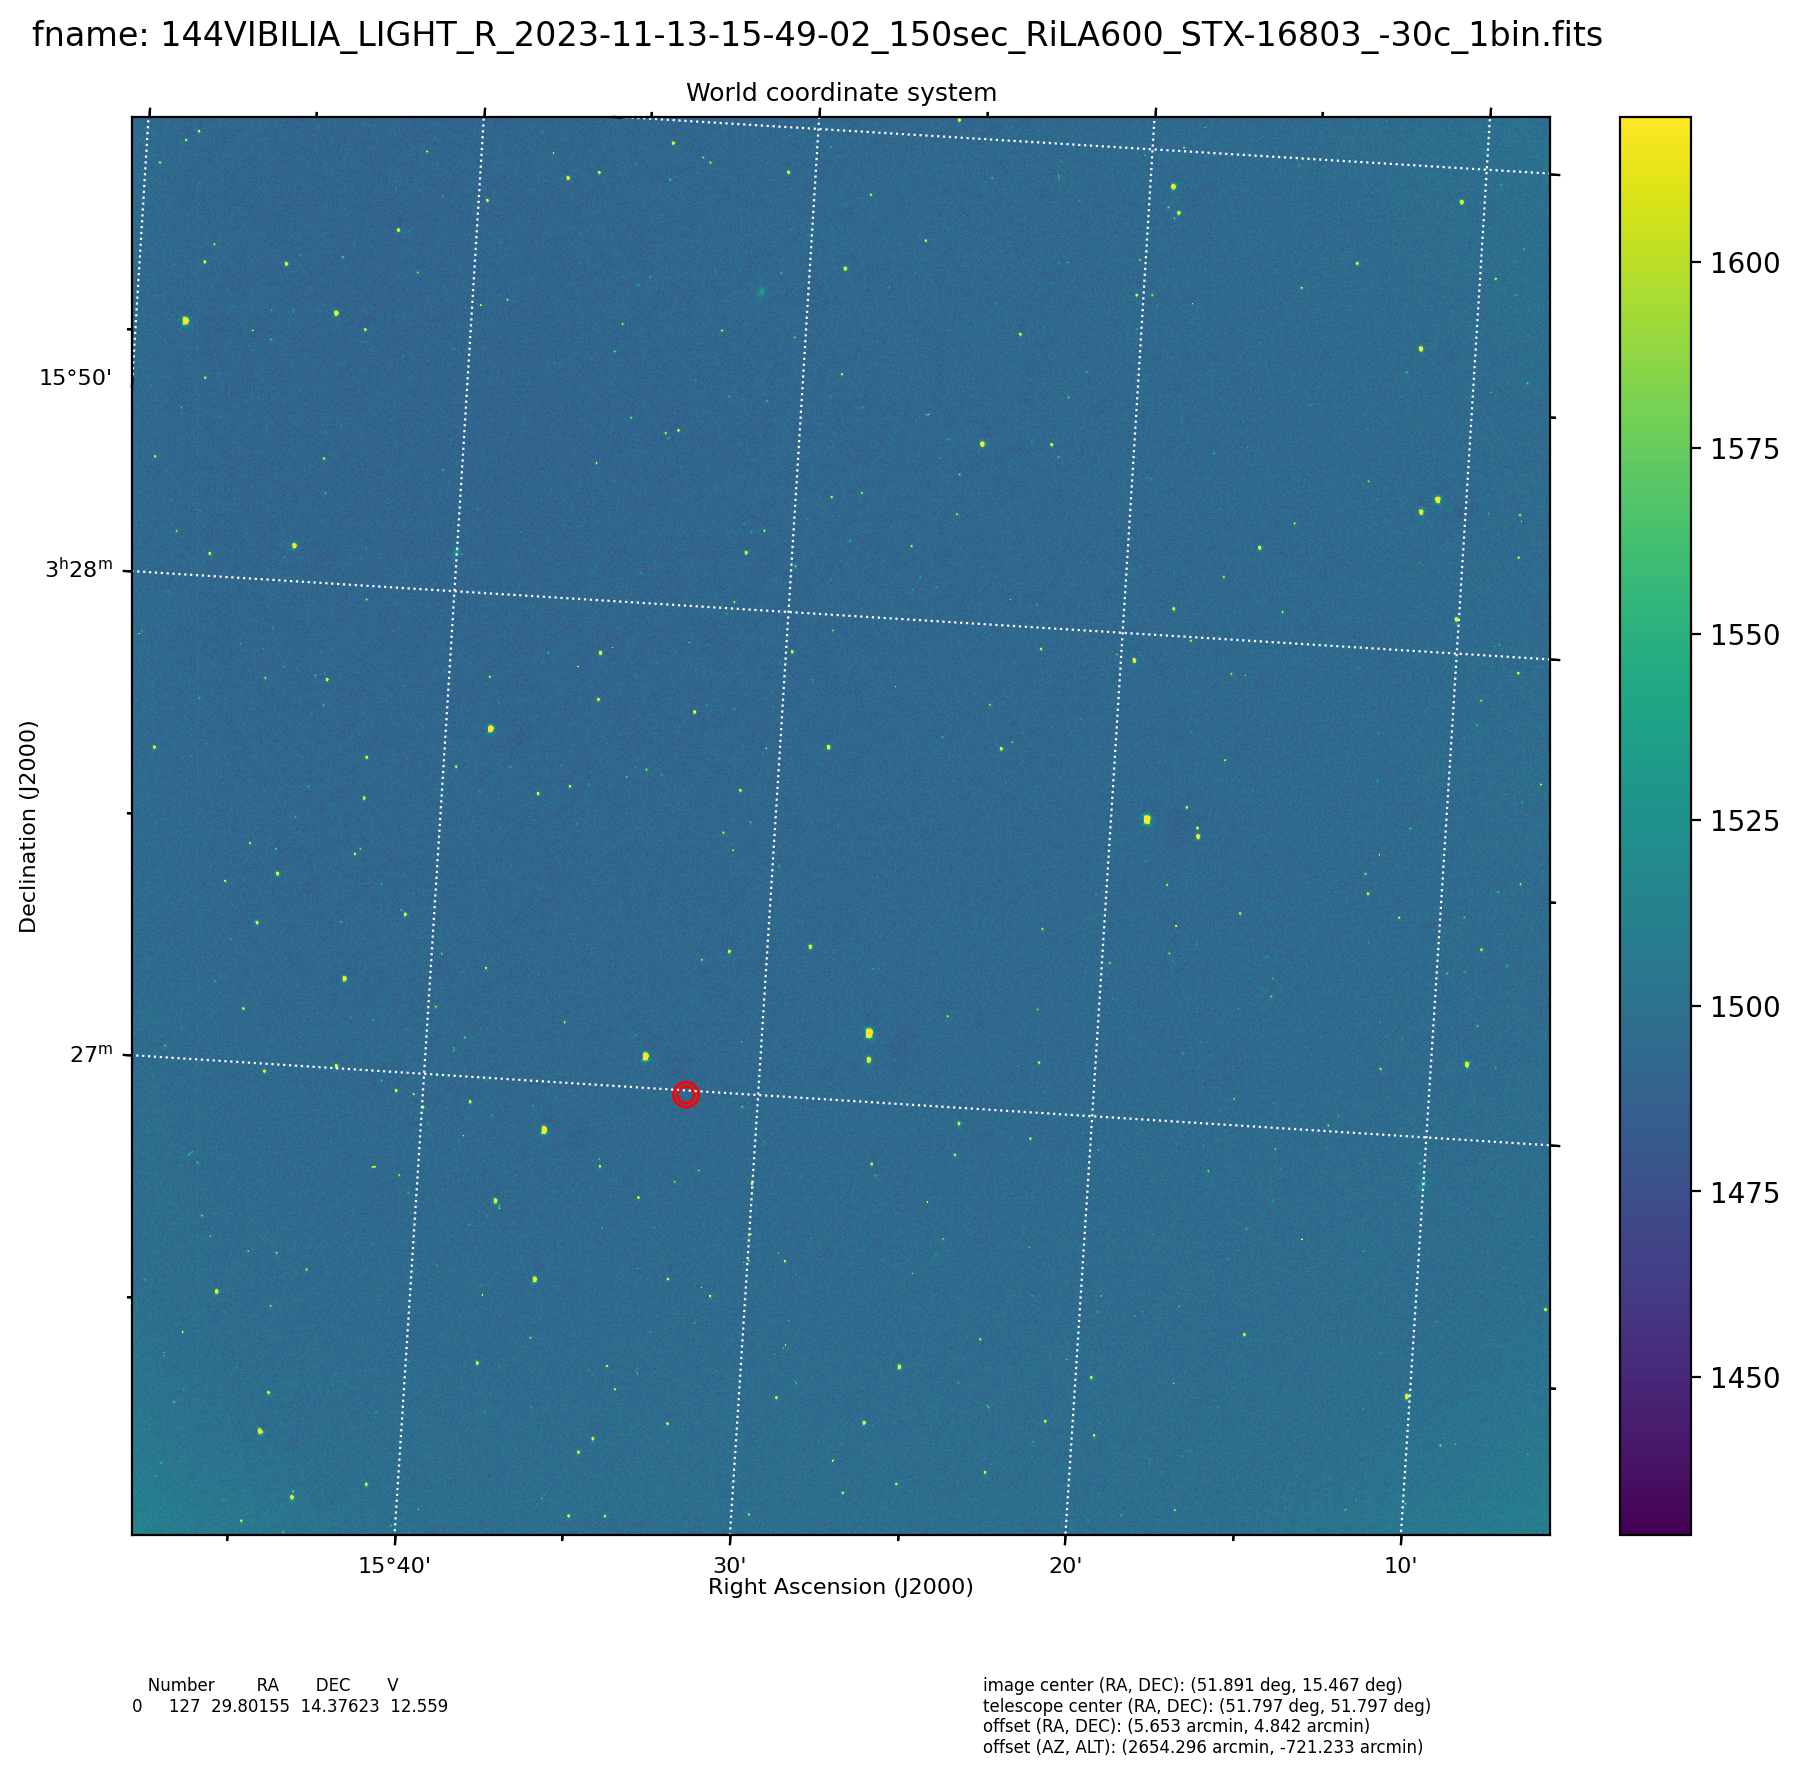

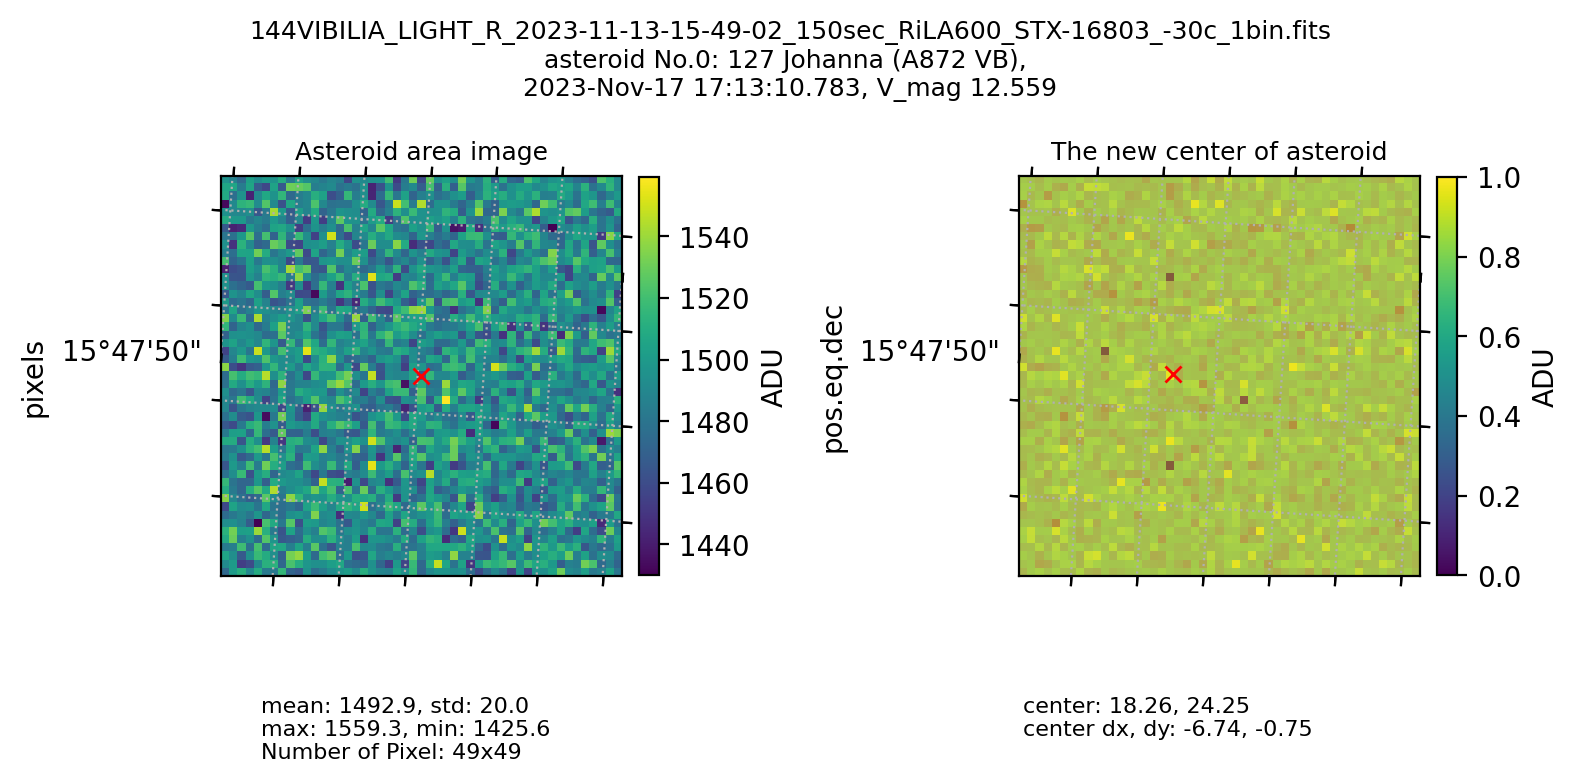

In [71]:
#(과제) 이곳에 코딩을 완성하여 제출하시오.
fpath = Path(fpaths[1])
hdul = fits.open(fpath)
wcs = WCS(hdul[0].header)

#######################################################
# optic and ccd
if hdul[0].header["CCDNAME"] == "STF-8300M" :
    val_figsize = (12, 9)
    gain = 0.37
    rdnoise = 9.3
    pix_size = 5.4 * u.um
    val_fraction = 0.035

if hdul[0].header["CCDNAME"] == "STX-16803" :
    val_figsize = (10, 9)
    gain = 1.27
    rdnoise = 9.0
    pix_size = 9 * u.um
    val_fraction = 0.0455

if hdul[0].header["OPTIC"] == "GSON300" :
    focal_length = 1200 * u.mm

if hdul[0].header["OPTIC"] == "RiLA600" :
    focal_length = 3000 * u.mm

print("rdnoise, gain, pix_size, focal_length :", rdnoise, gain, pix_size, focal_length)


#######################################################
# PIXSCALE
if 'PIXSCALE' in hdul[0].header:
    PIX2ARCSEC = hdul[0].header['PIXSCALE']
else :
    PIX2ARCSEC = 206265 * hdul[0].header['XPIXSZ'] ( hdul[0].header['XBINNING']  * hdul[0].header['FOCALLEN'])

PIX2ARCSEC = PIX2ARCSEC # * u.arcsec / u.pixel
print("PIX2ARCSEC :", PIX2ARCSEC)

SOLVE, ASTAP, LOCAL = checkPSolve(str(fpath))
print("SOLVE, ASTAP, LOCAL :", SOLVE, ASTAP, LOCAL)

#######################################################
# 아래에 코딩을 이어서 하시오.








rdnoise, gain, pix_size, focal_length : 9.0 1.27 9.0 um 3000.0 mm
PIX2ARCSEC : 0.618795
SOLVE, ASTAP, LOCAL : True True True


## (과제)

[이곳](https://drive.google.com/drive/folders/1snr5FvtlVbZ84xZiXU29qcpV3oCjNWta) 에 있는 소행성 914 PALISANA를 관측한 4개의 파일에 대해 위와 같이 소행성을 찾아 display 해 보시오.

In [72]:
#(과제) 이곳에 코딩을 완성하여 제출하시오.

fname2 = "914PALISANA_LIGHT_R_2016-10-31-16-45-43_100sec_RiLA600_STX-16803_-30c_2bin.fit"
fid2 = "1NnF8EbEW4W0Pod04CnnMU_JE8u1eRzoh"
# https://drive.google.com/file/d/1NnF8EbEW4W0Pod04CnnMU_JE8u1eRzoh/view?usp=sharing
fname3 = "file name here.fits"
fid3 = "google file id here"

fname4 = "file name here.fits"
fid4 = "google file id here"

fname5 = "file name here.fits"
fid5 = "google file id here"


# wget을 이용(나의 구글드라이브에서 공유한 파일을 구글 코랩에서 사용할 경우)
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid2}" -O {save_dir_name}/{fname2}
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid3}" -O {save_dir_name}/{fname3}
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid4}" -O {save_dir_name}/{fname4}
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id={fid5}" -O {save_dir_name}/{fname5}

# 이어서 코딩하시오..



--2024-12-02 06:44:45--  https://docs.google.com/uc?export=download&id=1NnF8EbEW4W0Pod04CnnMU_JE8u1eRzoh
Resolving docs.google.com (docs.google.com)... 142.250.31.100, 142.250.31.113, 142.250.31.139, ...
Connecting to docs.google.com (docs.google.com)|142.250.31.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1NnF8EbEW4W0Pod04CnnMU_JE8u1eRzoh&export=download [following]
--2024-12-02 06:44:45--  https://drive.usercontent.google.com/download?id=1NnF8EbEW4W0Pod04CnnMU_JE8u1eRzoh&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.253.63.132, 2607:f8b0:4004:c08::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.253.63.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16824960 (16M) [application/octet-stream]
Saving to: ‘Check_asteroids/914PALISANA_LIGHT_R_2016-10-31-16-45-43_100sec_RiLA600_STX-16803_-30c_